In [5]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from matplotlib import cm
import datetime
import pandas as pd
import seaborn as sns
%matplotlib inline
plt.style.use("seaborn")

import pymc3 as pm
from joblib import Parallel, delayed

import scipy.stats
import scipy.special
from scipy.optimize import minimize,basinhopping
from scipy.stats import norm
from pymc3.distributions.distribution import draw_values


In [6]:

class BayeOpt():
    def __init__(self,
                 obj_func,
                 x_range, 
                 init, 
                 kernel = "Matern52",
                 mean_func = False,
                 niter = 1000,
                 tune = 1500,
                 render = True, 
                 n_restarts = 2,
                 sample_method = "Metropolis",
                 BO_method = "MAP"): # replace Gaussian with Matern52 later
        """
        obj_func: objective functions (it should have two arguments: x and noise
        x_range: the upper bound and lower bounds
        init: initial data
        
        kernel: "Gaussian" or "Matern52" 
        mean_func: whether prior contains mean
        
        render: True or False  whether to plot acufunctions
        n_restarts: initial points to find minimums
        """
        # data parameters
        self.obj_func = obj_func
        
        self.x_min = np.array(x_range[0]).reshape(-1,) # assume x y are all continuous first
        self.x_max = np.array(x_range[1]).reshape(-1,) # x_min and max 's shape == (self.dim,1)
        self.dim = self.x_min.size
        self.bounds = np.array([[low, high] for low, high in zip(self.x_min, self.x_max)])
        
        
        
        self.x = np.array(init)
        self.y = np.array([obj_func(t) for t in self.x]).reshape(-1,)
        
        # GP parameters
        self.kernel = kernel
        self.mean_func = mean_func
        self.prior = {'nu': 1,'theta0': 1,'theta': 1,'alpha': 1,"beta": 1\
                     ,"alpha0": 1,"beta0": 1}
        self.gp = None
        self.trace = None
        self.sample_method = sample_method   # "NUTS", "Metropolis"
        self.niter = niter
        self.tune = tune
        self.ts = None # the traces for prediction
        
        # Bay_opt
        self.render=render
        self.n_restarts = n_restarts
        self.f_best = self.y.min()
        self.BO_method = BO_method
    
    def _GP_model(self):
        """
        Using PyMC3 to fit the hyperparameters
        BO_method: "MAP" or "MCMC"
        """
        
        with pm.Model() as self.model:
            theta = pm.Gamma("theta",alpha=self.prior['alpha'],beta=self.prior['beta'])#(self.dim,)
            theta0 = pm.Gamma("theta0",alpha=self.prior['alpha0'],beta=self.prior['beta0']) 
            #theta = self.prior['alpha']
            #theta0 = self.prior['alpha0']
            if self.kernel == "Matern52":
                cov_func = theta0**2 * pm.gp.cov.Matern52(input_dim = self.dim,ls = theta)
            elif self.kernel == "Gaussian":
                cov_func = theta0**2 * pm.gp.cov.ExpQuad(input_dim = self.dim,ls = theta)
            
            if self.mean_func == True:
                m = pm.gp.mean.Constant(self.y.mean())
                self.gp = pm.gp.Marginal(mean_func = m, cov_func = cov_func)
            else:
                self.gp = pm.gp.Marginal(cov_func = cov_func)
            
            nu = pm.HalfCauchy("nu",self.prior['nu']) # noise.
            margin = self.gp.marginal_likelihood("margin", X=self.x, y=self.y, noise=nu)
            if self.BO_method == "MCMC":
                # print("x y list:",self.x,self.y)
                if self.sample_method == "Metropolis":
                    step = pm.Metropolis()
                if self.sample_method == "NUTS":
                    step = pm.NUTS()
                self.trace = pm.sample(self.niter, step=step, progressbar=True, tune=self.tune)
                pm.traceplot(self.trace)
            elif self.BO_method == "MAP":
                self.trace = pm.find_MAP()
                print("MAP:",self.trace)
        
        
    
    def _get_ts(self,samples):
        self.ts = np.random.randint(self.niter, size = samples)
    
    def _predict_GP(self, X_new,pred_noise = False):
        """
        samples = the size of trade
        """
        if self.ts is None:
            mu,var = self.gp.predict(X_new,point=self.trace,diag=True,pred_noise=False)
            return mu, var
        else:
            mean = np.zeros(shape=(len(self.ts),X_new.shape[0]))
            var = np.zeros(shape=(len(self.ts), X_new.shape[0]))
            mu, cov = self.gp.predictt(X_new, diag=True, pred_noise=False)
            for i,t in enumerate(self.ts):
                m,v = draw_values([mu,cov], point = self.trace[t])
                mean[i] = m
                var[i] = v
            return mean, var
    
   

    
    
    def Sampling(self, samples):
        '''
        samples is the argument for _predict_GP
        
        '''
        self._GP_model()
        if self.BO_method == "MCMC":
            self._get_ts(samples)
        else:
            self.ts = None
        pred_y,_ = self._predict_GP(self.x)
        self.f_best = pred_y.min()   #######
        x_next = self.Get_next()
        return x_next
    
    
    def acq(self, x_star,param):
        x_star = np.array(x_star) #.reshape(-1,1) #.reshape(1,-1)
        if param is None:
            mean,var = self._predict_GP(x_star)
        else:
            mean, var = self.gp.predict(x_star,point=param,diag=True,pred_noise=False)
        # print("mean:",mean)    
        std = np.sqrt(var)  #[0]
        
        gamma = (-self.f_best+mean)/std
        res = std*(norm.cdf(gamma)*gamma+norm.pdf(gamma))
        return np.sum(res,axis = 0) if param is None else res
        
    
     
    def Get_next(self, param = None):
        
        min_val = float("inf")
        min_x = None
        
        # define acqusition function
        def min_obj(X):
        # Minimization objective is the negative acquisition function
            return self.acq(X.reshape(-1,self.dim), param = param)
     
        
        # optimize
        #for x0 in np.random.uniform(self.bounds[:,0], self.bounds[:,1], size=(self.n_restarts, self.dim)):
        #    res = minimize(min_obj, x0=x0, bounds=self.bounds, method='L-BFGS-B')   
        #    # print(res.fun,min_val)
        #    if res.fun < min_val:
        #        min_val = res.fun
        #        #print(min_val,res.fun)
        #        min_x = res.x  
        #        # print(min_x)
        
        #parallel
        xs = np.random.uniform(self.bounds[:,0], self.bounds[:,1], size=(self.n_restarts, self.dim))
        
        opt = Parallel()(delayed(minimize)(fun = min_obj, 
                                                    x0=x, 
                                                    bounds=self.bounds, 
                                                    method='L-BFGS-B') for x in xs)
        
          
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])

            
        x_next = x_best[np.argmin(f_best)]
        # print("x_next:",x_next)
        if self.render == True:
            self.Render(x_next,param)
        return x_next
    
    
    def Iteration(self,max_iter = 5, samples = 4):
        for i in range(max_iter):
            x_new = self.Sampling(samples)

            print("\nx new:",x_new)
            y_new = self.obj_func(x_new)
            print('\ny new:',y_new)
            self.x = np.vstack((self.x,x_new))
            self.y = np.hstack((self.y,y_new))
            #self.f_best = self.y.min()
    #             if i > 0 and np.linalg.norm(x_new-self.x[-2])*10000 < self.x_range:
    #                 break
        return self.x[np.argmin(self.y)]

    def plot_dist(self, size):
        self.render = False
        self.BO_method = "MCMC"
        self._GP_model()
        ts = np.random.randint(self.niter, size = size)
        x_next_ls = []
        for t in ts: # Remove this thinning later
            pred_y,_ = self.gp.predict(self.x,point=self.trace[t],diag=True,pred_noise=False)
            self.f_best = pred_y.min()
            x_next = self.Get_next(param=self.trace[t])
            x_next_ls.append(x_next)
        return x_next_ls
    
    def Render(self,point,param = None):
        plt.figure(figsize=(6,3))
        plt.subplot(2, 1, 1)
        x = np.linspace(self.x_min,self.x_max,100)
        y = self.obj_func(x,0)
        mean,var = self._predict_GP(x)
        mean = np.mean(mean,axis = 0) if param is None else mean
        var = np.mean(var,axis = 0) if param is None else var
        plt.xlim(self.x_min,self.x_max)
        plt.plot(x,y,c="k",label="unknown target function")
        plt.fill_between(x.ravel(), 
                         mean.ravel() + 1.96 * np.sqrt(var), 
                         mean.ravel() - 1.96 * np.sqrt(var), 
                         alpha=0.2) 
        plt.plot(x,mean,c="r",label="gp")
        plt.scatter(self.x, self.y, marker='o', color="b",label="existing")
        plt.plot([point], [self.obj_func(point)], marker='o', markersize=10, color="red",label="next one")
        plt.legend(loc="best")
        
        plt.subplot(2, 1, 2)
        plt.xlim(self.x_min,self.x_max)
        y2 = self.acq(x.reshape(-1,1),param)
        print(x[np.argmin(y2)])
        plt.plot(x,y2,c="k",label="acq function")
        plt.show()

In [20]:
np.sum(np.array([[1,2,3,4]]),axis = 0)

array([1, 2, 3, 4])

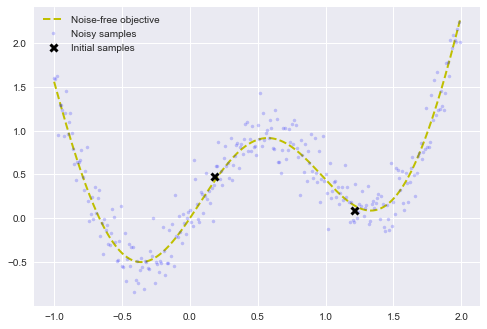

In [10]:
def f(X, noise = 0.2):
    return -1 * (-np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape))
g_range = np.array([-1.0, 2.0])

X_init = np.random.uniform(g_range[0], g_range[1], size=(2,1))

#X_init = np.array([[-0.74808803],
#                   [ 0.78671284],
#                   [ 0.50401849],
#                   [ 1.76894379]])

X = np.arange(g_range[0], g_range[1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)
# Plot optimization objective with noise level 
plt.plot(X, Y, 'y--', lw=2, label='Noise-free objective')
plt.plot(X, f(X), 'b.', alpha=0.2, label='Noisy samples')
plt.plot(X_init, f(X_init), 'kx', mew=3, label='Initial samples')
plt.legend();

In [30]:
X_init

array([[-0.74808803],
       [ 0.78671284],
       [ 0.50401849],
       [ 1.76894379]])

In [51]:
baye_1d_GP_MCMC_EI = BayeOpt(obj_func=f,init = X_init, x_range=g_range, kernel = "Matern52",BO_method = "MCMC")


INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /

[-1.]


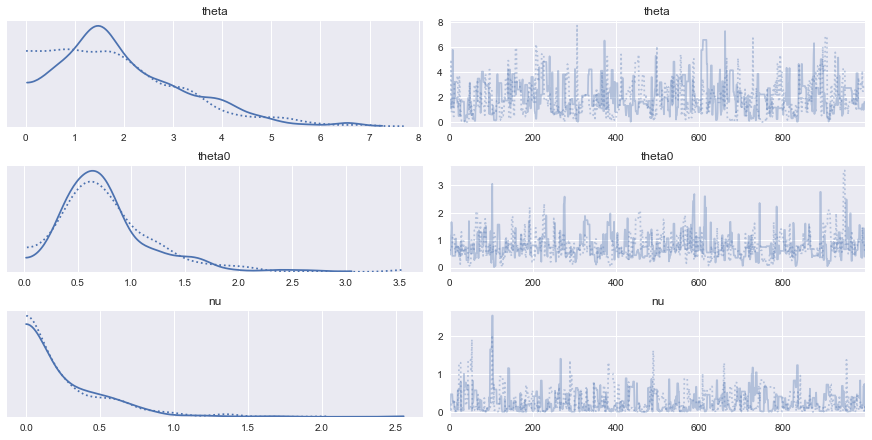

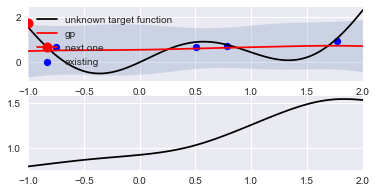


x new: [-1.]

y new: [1.96114041]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /Users/shen

[0.45454545]


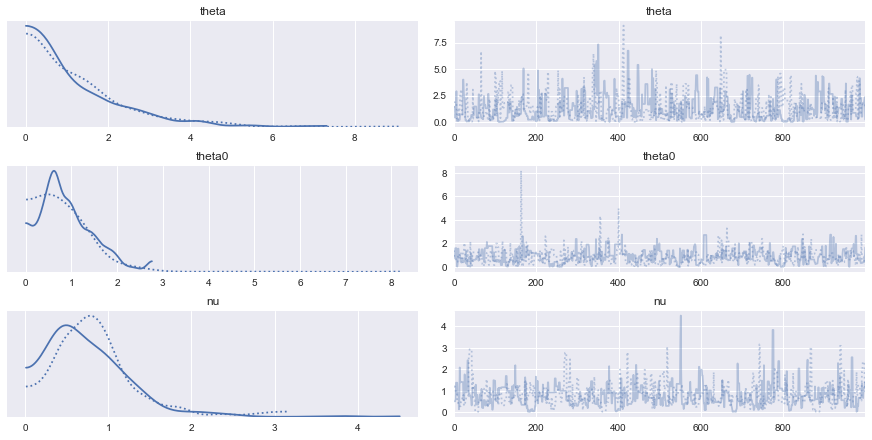

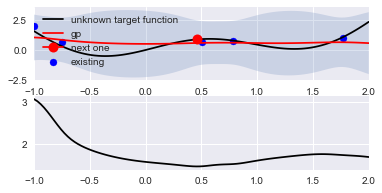


x new: [0.46217766]

y new: [0.94069691]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /

[2.]


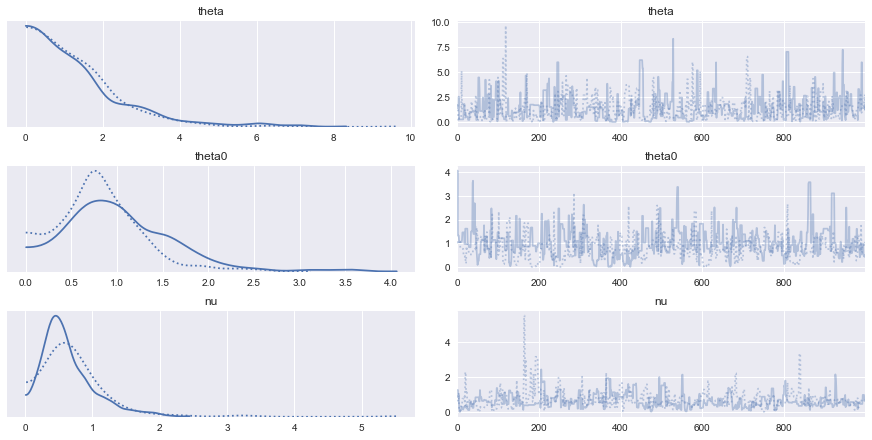

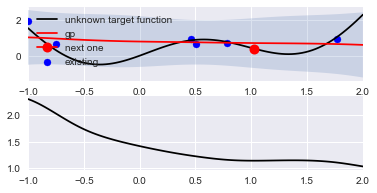


x new: [1.02547375]

y new: [0.70177778]


INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /Users/shen

[2.]


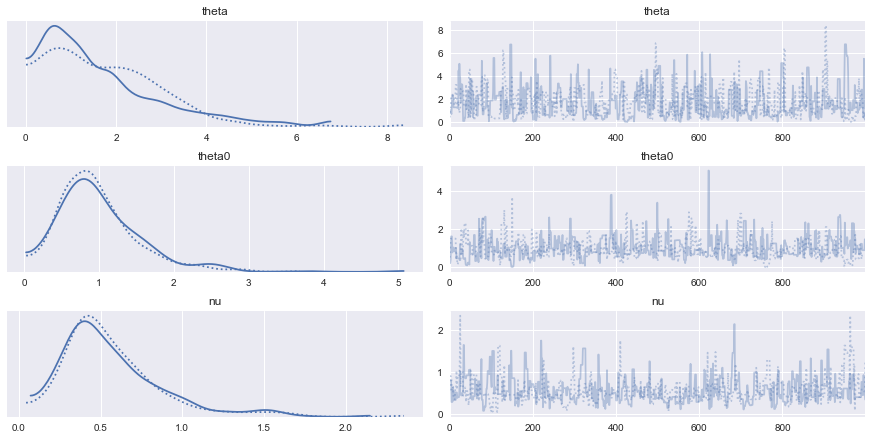

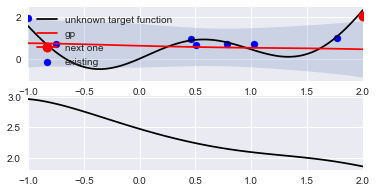


x new: [2.]

y new: [2.28633564]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /

[0.75757576]


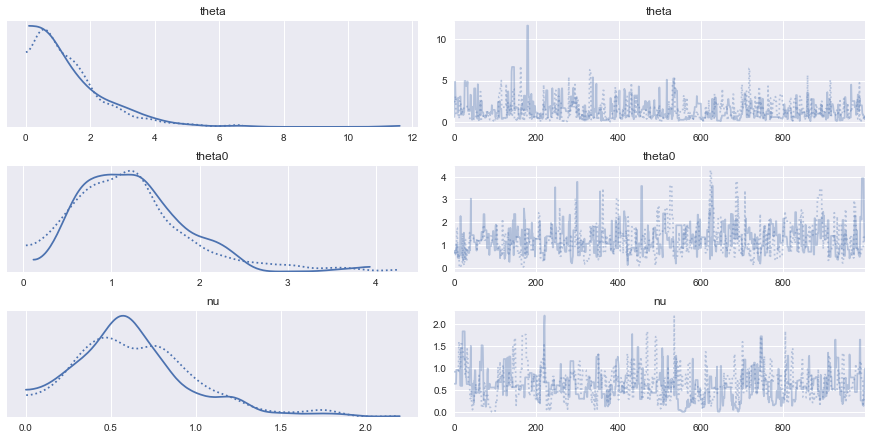

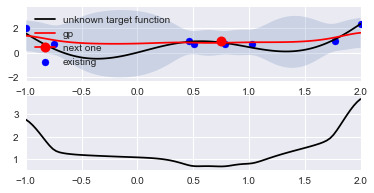


x new: [0.74859771]

y new: [0.53750734]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 5 seconds.
The estimated number of effective samples is smaller than 200 for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /

[0.75757576]


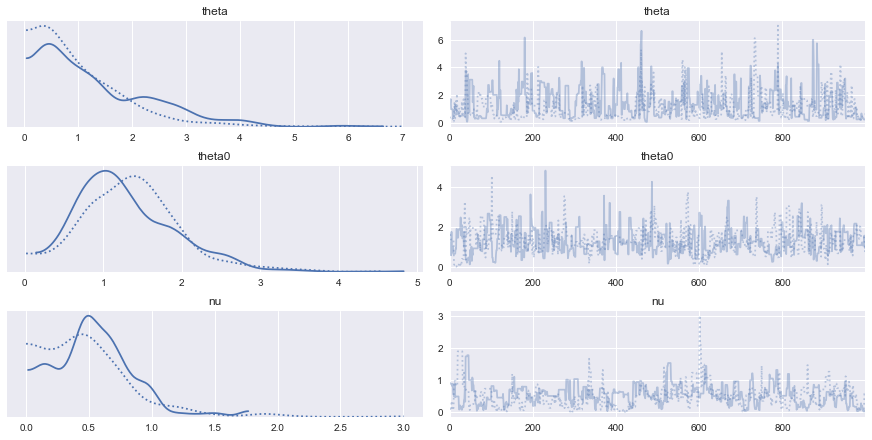

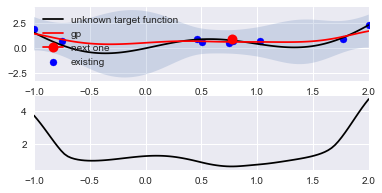


x new: [0.77076706]

y new: [0.87118527]


array([0.74859771])

In [52]:
baye_1d_GP_MCMC_EI.Iteration(max_iter = 6, samples = 4)

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/thean

[0.09090909]


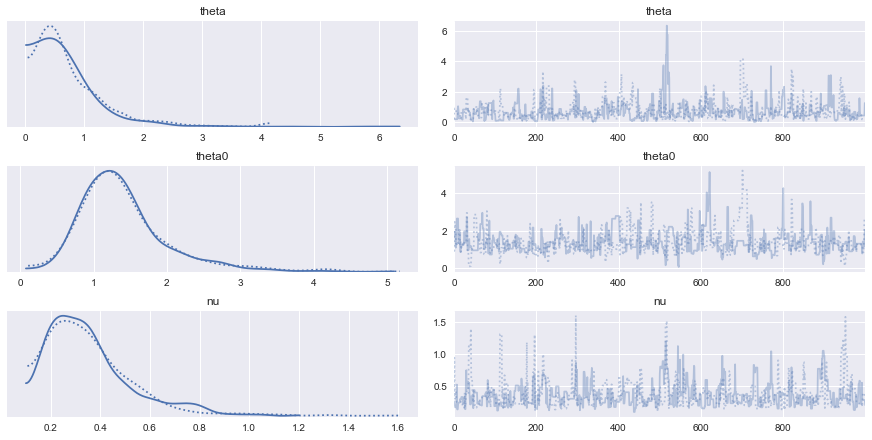

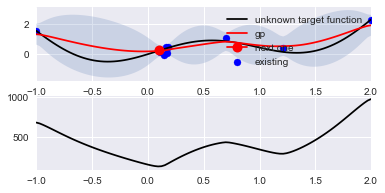


x new: [0.09838991]

y new: [0.0825349]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 5 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/thean

[0.09090909]


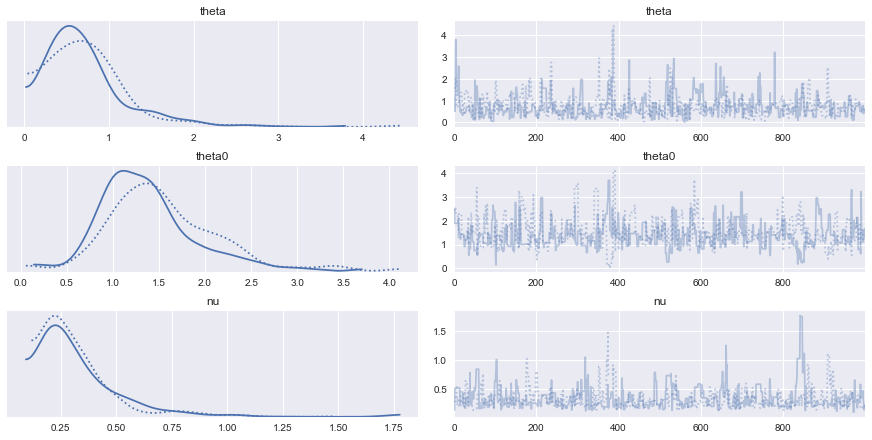

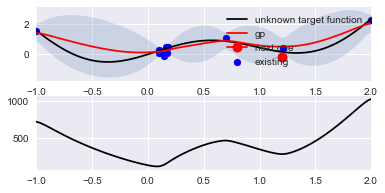


x new: [1.20210621]

y new: [0.34895369]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [nu]
>Metropolis: [theta0]
>Metropolis: [theta]


Sampling 2 chains for 1_500 tune and 1_000 draw iterations (3_000 + 2_000 draws total) took 6 seconds.
The number of effective samples is smaller than 25% for some parameters.
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


KeyboardInterrupt: 

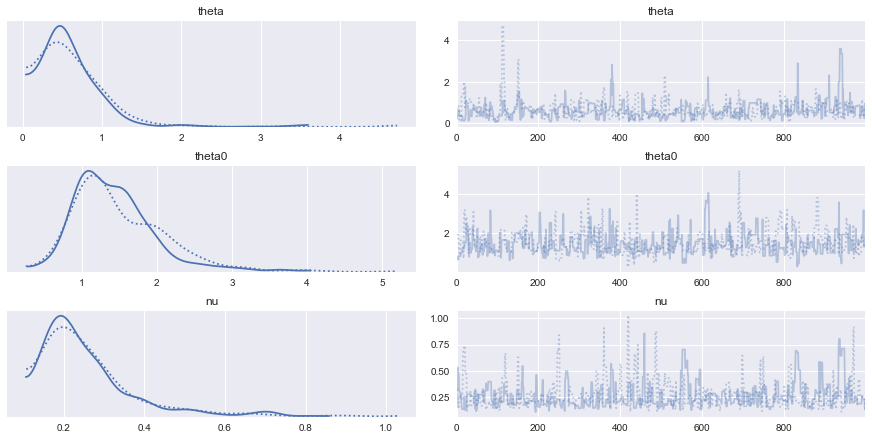

In [13]:
start = datetime.datetime.now()
#baye_1d_GP_MCMC_EI2 = BayeOpt(obj_func=f,init = X_init, x_range=g_range, kernel = "Matern52",BO_method = "MCMC")
res = baye_1d_GP_MCMC_EI2.Iteration(max_iter = 4, samples = baye_1d_GP_MCMC_EI2.niter//2)

end = datetime.datetime.now()
print (end-start)



/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarni

/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(0.7604214), 'theta0_log__': array(-0.49528494), 'nu_log__': array(-11.70072443), 'theta': array(2.13917748), 'theta0': array(0.60939724), 'nu': array(8.28781305e-06)}


INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock
INFO (theano.gof.compilelock): Refreshing lock /Users/shenyue/.theano/compiledir_Darwin-19.5.0-x86_64-i386-64bit-i386-3.7.1-64/lock_dir/lock


TypeError: object of type 'NoneType' has no len()

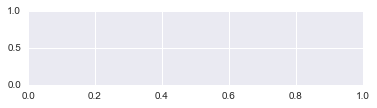

In [33]:
start = datetime.datetime.now()
baye_1d_GP_MCMC_EI2 = BayeOpt(obj_func=f,init = X_init, x_range=g_range, kernel = "Matern52",BO_method = "MAP")
res = baye_1d_GP_MCMC_EI2.Iteration(max_iter = 6, samples = 100)

end = datetime.datetime.now()
print (end-start)



In [52]:
baye_1d_GP_MCMC_EI.trace

{'theta_log__': array(-1.20075377),
 'theta0_log__': array(-0.23503058),
 'nu_log__': array(-1.19065581),
 'theta': array(0.30096727),
 'theta0': array(0.79054668),
 'nu': array(0.30402182)}

In [51]:
baye_1d_GP_MCMC_EI1.Iteration(max_iter = 6, samples = 4)

TypeError: __init__() got an unexpected keyword argument 'sigma'

In [38]:
baye_1d_GP_MCMC_EI2 = BayeOpt(obj_func=f,init = X_init, x_range=g_range, kernel = "Matern52",BO_method = "MAP")



In [39]:
baye_1d_GP_MCMC_EI.x

array([[1.88814663],
       [1.27454126],
       [0.01316959],
       [0.72022157]])


MAP: {'theta_log__': array(-24.69789608), 'theta0_log__': array(-12.61308657), 'nu_log__': array(-0.24552329), 'theta': array(1.87862465e-11), 'theta0': array(3.32817462e-06), 'nu': array(0.78229506)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[-1.]


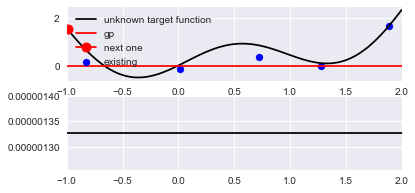


x new: [-0.9883016]

y new: [1.6129931]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(-22.72152947), 'theta0_log__': array(-15.48757195), 'nu_log__': array(-0.03913465), 'theta': array(1.35570479e-10), 'theta0': array(1.87859414e-07), 'nu': array(0.96162122)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[-1.]


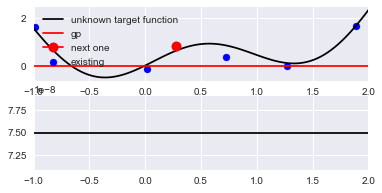


x new: [0.27425873]

y new: [0.19540805]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(-13.15946323), 'theta0_log__': array(-0.10874273), 'nu_log__': array(-4.16268835), 'theta': array(1.92715982e-06), 'theta0': array(0.89696115), 'nu': array(0.01556566)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[-1.]


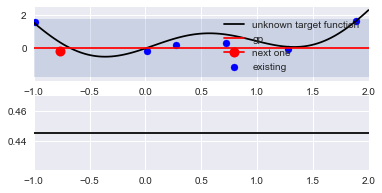


x new: [-0.76418476]

y new: [0.65050678]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(-1.3706832), 'theta0_log__': array(-0.15538934), 'nu_log__': array(-6.53219385), 'theta': array(0.25393341), 'theta0': array(0.85608181), 'nu': array(0.00145581)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[0.]


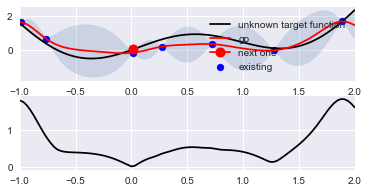


x new: [0.01305055]

y new: [0.1209448]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(-1.29065886), 'theta0_log__': array(-0.18915895), 'nu_log__': array(-1.61155453), 'theta': array(0.27508948), 'theta0': array(0.82765494), 'nu': array(0.19957712)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[0.]


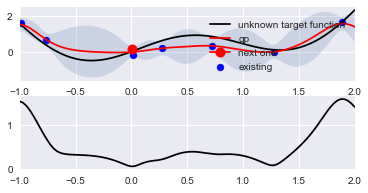


x new: [0.00805384]

y new: [0.44378391]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(-1.20075377), 'theta0_log__': array(-0.23503058), 'nu_log__': array(-1.19065581), 'theta': array(0.30096727), 'theta0': array(0.79054668), 'nu': array(0.30402182)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[1.24242424]


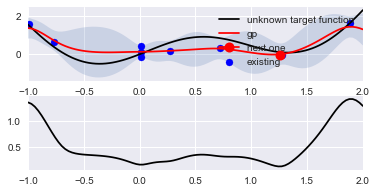


x new: [1.2543431]

y new: [0.13760408]


In [41]:
#start = datetime.datetime.now()
res = baye_1d_GP_MCMC_EI.Iteration(max_iter = 6)
#end = datetime.datetime.now()
#print (end-start)


In [225]:
baye_1d_GP_MCMC_EI.plot_dist()

0:23:55.189234


In [9]:
baye_1d_GP_MCMC_EI = BayeOpt(obj_func=f,init = X_init, x_range=g_range, kernel = "Matern52")

In [10]:
baye_1d_GP_MCMC_EI.x

array([[-0.7],
       [ 0. ],
       [ 0.5],
       [ 1.5]])

In [11]:
baye_1d_GP_MCMC_EI.BO_method

'MAP'


MAP: {'theta_log__': array(-19.51911624), 'theta0_log__': array(-21.71226908), 'nu_log__': array(-0.8490921), 'theta': array(3.33392269e-09), 'theta0': array(3.71947247e-10), 'nu': array(0.42780316)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x
/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this w

[0.]


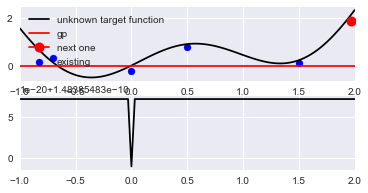


x new: [1.96645478]

y new: [1.83031125]


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x



MAP: {'theta_log__': array(-19.43414288), 'theta0_log__': array(-11.74339035), 'nu_log__': array(-0.17133683), 'theta': array(3.62960186e-09), 'theta0': array(7.94164322e-06), 'nu': array(0.84253773)}


/Users/shenyue/anaconda3/lib/python3.7/site-packages/theano/tensor/basic.py:6611: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result[diagonal_slice] = x


[0.]


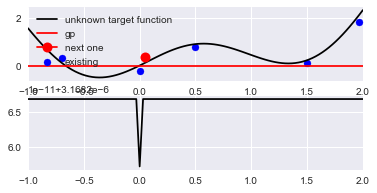


x new: [0.05109485]

y new: [0.1513748]


array([0.])

In [12]:
baye_1d_GP_MCMC_EI.Iteration(max_iter = 2)